In [ ]:
!pip install kornia

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import cv2
import kornia
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


In [ ]:
# Define the Generator and Discriminator networks (DCGAN architecture)
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        self.rotation_head = nn.Linear(768, 4)



    def forward(self, z):
        img = self.model(z)
        rotation_pred = self.rotation_head(img.view(img.size(0), 768))


        return img, rotation_pred

num_classes = 10  # For CIFAR-10

class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, img):
        return self.model(img)





In [ ]:

# Hyperparameters
latent_dim = 100
img_channels = 3  # CIFAR-10 images are in RGB, so 3 channels
batch_size = 64
lr = 0.0002
epochs = 30
sample_interval = 100  # Interval to save generated samples

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize networks and optimizers
generator = Generator(latent_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()


transform = transforms.Compose([
    transforms.Resize(70),  # Resize images to be slightly larger than the crop size
    transforms.RandomCrop(64, padding=4),  # Then apply RandomCrop
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10, interpolation=3, fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])




In [ ]:
dataloader = DataLoader(
    datasets.CIFAR10('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)


Files already downloaded and verified


In [ ]:
import torchvision.utils as vutils

# Create lists to store losses
d_losses = []
g_losses = []
rotation_losses = []
ssim_values = []


# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        batch_size = imgs.size(0)

        # Random rotations for self-supervised task
        angle_classes = torch.randint(0, 4, (batch_size,)).to(device)
        angles = angle_classes.float() * 90.0 * (np.pi/180.0)  # Convert to radians
        # Ensure imgs is on the same device as angles
        imgs = imgs.to(device)

        # Now perform the rotation
        rotated_imgs = kornia.geometry.rotate(imgs, angles)

        #rotated_imgs = kornia.geometry.rotate(imgs, angles)

        # Train Discriminator on rotated real images
        optimizer_D.zero_grad()
        real_outputs = discriminator(rotated_imgs)
        real_labels = torch.ones_like(real_outputs)
        real_loss = criterion(real_outputs, real_labels)

        noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images, _ = generator(noise)
        fake_outputs = discriminator(fake_images.detach())
        fake_labels = torch.zeros_like(fake_outputs)
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator on fake images and rotation prediction
        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, torch.ones_like(fake_outputs))

        _, rotation_preds = generator(noise)
        rot_loss = nn.CrossEntropyLoss()(rotation_preds, angle_classes)

        total_g_loss = g_loss + rot_loss
        total_g_loss.backward()
        optimizer_G.step()

        # Print progress
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}] [Rotation loss: {rot_loss.item()}]")

        # Append losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        rotation_losses.append(rot_loss.item())

    # Save generated images at specified intervals
    if epoch % sample_interval == 0:
        with torch.no_grad():
            noise = torch.randn(25, latent_dim, 1, 1).to(device)
            generated_images, _ = generator(noise)
            generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]




            # # Plot the generated images
            # fig, ax = plt.subplots()
            # ax.imshow(np.transpose(vutils.make_grid(generated_images.device(), padding=2, normalize=True), (1,2,0)))
            # plt.show()




[Epoch 0/30] [Batch 0/782] [D loss: 1.3998159170150757] [G loss: 1.6596307754516602] [Rotation loss: 1.4047341346740723]
[Epoch 0/30] [Batch 100/782] [D loss: 0.01267989631742239] [G loss: 6.124722957611084] [Rotation loss: 1.4036520719528198]
[Epoch 0/30] [Batch 200/782] [D loss: 0.0062872967682778835] [G loss: 6.378811836242676] [Rotation loss: 1.3998687267303467]
[Epoch 0/30] [Batch 300/782] [D loss: 0.005714341066777706] [G loss: 6.54118013381958] [Rotation loss: 1.3840124607086182]
[Epoch 0/30] [Batch 400/782] [D loss: 0.0036361722741276026] [G loss: 7.100228786468506] [Rotation loss: 1.401260495185852]
[Epoch 0/30] [Batch 500/782] [D loss: 0.0032254671677947044] [G loss: 7.111000061035156] [Rotation loss: 1.3604768514633179]
[Epoch 0/30] [Batch 600/782] [D loss: 0.005798253230750561] [G loss: 6.699202537536621] [Rotation loss: 1.388498306274414]
[Epoch 0/30] [Batch 700/782] [D loss: 0.003961125388741493] [G loss: 6.978245735168457] [Rotation loss: 1.399300217628479]
[Epoch 1/30] 

In [ ]:

# # Save the generator and discriminator models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


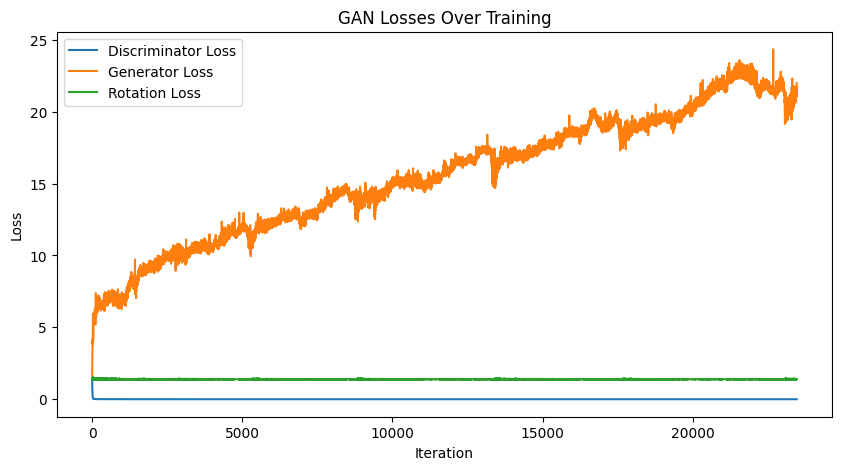

In [ ]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.plot(rotation_losses, label="Rotation Loss")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("GAN Losses Over Training")
plt.show()



In [ ]:
# import matplotlib.pyplot as plt
# import torchvision.utils as vutils

# # Load the saved generator model
# generator.load_state_dict(torch.load('generator.pth'))
# generator.eval()

# # Generate a batch of fake images
# with torch.no_grad():
#     noise = torch.randn(25, latent_dim, 1, 1)
#     generated_images, _ = generator(noise)

#     generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]


# # Display the generated images in a grid
# fig = plt.figure(figsize=(5, 5))
# plt.axis("off")
# plt.title("Generated Images")
# plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True), (1, 2, 0)))
# plt.show()


In [ ]:
class DiscriminatorForClassification(nn.Module):
    def __init__(self, img_channels, num_classes=10):
        super(DiscriminatorForClassification, self).__init__()
        # Define your convolutional layers here
        self.features = nn.Sequential(
            # Assuming these are your convolutional layers
            nn.Conv2d(img_channels, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # Add more layers as needed
        )

        self.flatten_size = self._get_flatten_size((img_channels, 64, 64))
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_size, num_classes)
        )

    def _get_flatten_size(self, input_shape):
        with torch.no_grad():
            input = torch.zeros(1, *input_shape)
            output = self.features(input)
            return int(np.prod(output.size()[1:]))

    def forward(self, img):
        out = self.features(img)
        out = out.view(out.size(0), -1)
        class_output = self.classifier(out)
        return class_output



In [ ]:
# Load the discriminator with the pre-trained weights
pretrained_discriminator = Discriminator(img_channels).to(device)
pretrained_discriminator.load_state_dict(torch.load('discriminator.pth'))

# Create the new discriminator for classification
discriminator_classifier = DiscriminatorForClassification(img_channels).to(device)

# Transfer weights from pretrained discriminator, except for the classifier layer
discriminator_classifier.features.load_state_dict(pretrained_discriminator.model.state_dict(), strict=False)

# Define a new optimizer and loss function for fine-tuning
optimizer = optim.Adam(discriminator_classifier.parameters(), lr=0.0002)
criterion = nn.CrossEntropyLoss()

# Fine-tuning loop
for epoch in range(30):
    for i, (imgs, labels) in enumerate(dataloader):
        imgs, labels = imgs.to(device), labels.to(device)

        # Forward pass
        outputs = discriminator_classifier(imgs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{30}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}')



Epoch [1/30], Step [100/782], Loss: 2.960214376449585
Epoch [1/30], Step [200/782], Loss: 1.8694764375686646
Epoch [1/30], Step [300/782], Loss: 2.0653958320617676
Epoch [1/30], Step [400/782], Loss: 2.2134151458740234
Epoch [1/30], Step [500/782], Loss: 2.0582687854766846
Epoch [1/30], Step [600/782], Loss: 2.027768611907959
Epoch [1/30], Step [700/782], Loss: 2.227799654006958
Epoch [2/30], Step [100/782], Loss: 2.035475015640259
Epoch [2/30], Step [200/782], Loss: 1.6228042840957642
Epoch [2/30], Step [300/782], Loss: 2.081251621246338
Epoch [2/30], Step [400/782], Loss: 1.826735496520996
Epoch [2/30], Step [500/782], Loss: 2.230545997619629
Epoch [2/30], Step [600/782], Loss: 2.031341314315796
Epoch [2/30], Step [700/782], Loss: 1.753211259841919
Epoch [3/30], Step [100/782], Loss: 1.976358413696289
Epoch [3/30], Step [200/782], Loss: 2.0537774562835693
Epoch [3/30], Step [300/782], Loss: 1.5173548460006714
Epoch [3/30], Step [400/782], Loss: 1.8623158931732178
Epoch [3/30], Step [

In [ ]:
# Assuming you have already defined 'transform', 'batch_size', and other necessary imports

test_transform = transforms.Compose([
    transforms.Resize(64),           # Resize to match training images (if you resized them)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_dataset = datasets.CIFAR10('data', train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:  # Assuming test_loader is your DataLoader for test data
        images, labels = images.to(device), labels.to(device)
        outputs = discriminator_classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy}%')


Accuracy of the model on the test images: 64.15%


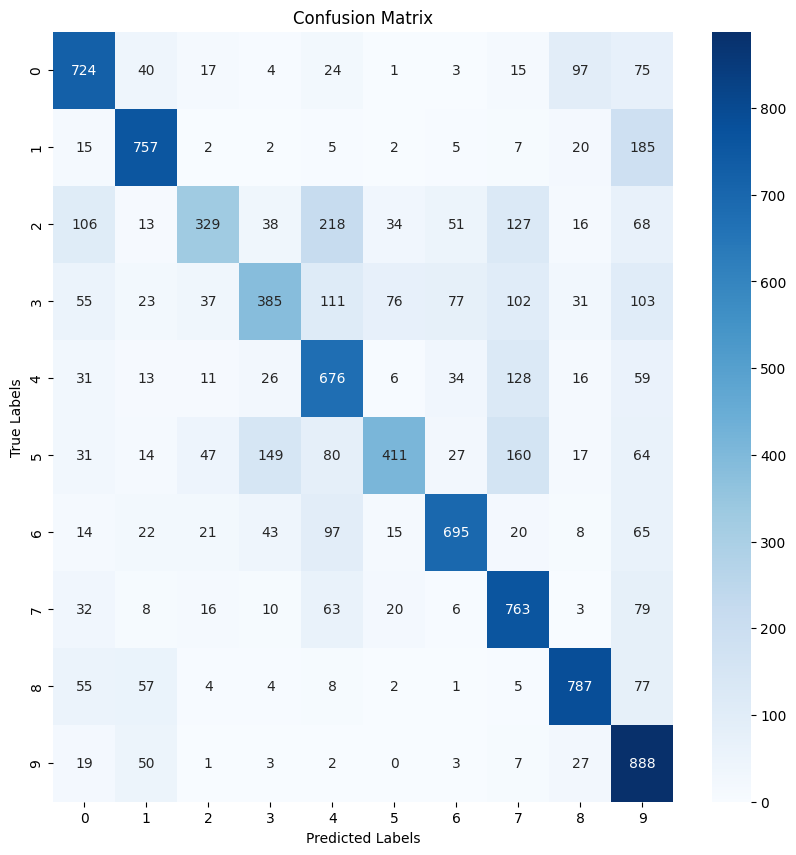

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_predicted = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = discriminator_classifier(images)
        _, predicted = torch.max(outputs, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from lpips import LPIPS

# Load the saved generator model
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

# Create a DataLoader for real images
real_transform = transforms.Compose([
    transforms.Resize(256),  # Resize images to a larger size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

real_dataset = datasets.CIFAR10('data', train=True, download=True, transform=real_transform)
real_dataloader = DataLoader(real_dataset, batch_size=64, shuffle=True)

# Initialize LPIPS metric
lpips_metric = LPIPS(net='alex', spatial=True)  # Use 'spatial' for spatial LPIPS

# Calculate LPIPS for generated images
lpips_score = 0.0
num_batches = 0

with torch.no_grad():
    for i, (real_images, _) in enumerate(real_dataloader):
        # Generate fake images
        batch_size = real_images.size(0)
        noise = torch.randn(batch_size, latent_dim, 1, 1)
        generated_images, _ = generator(noise)

        generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

        # Resize generated images to match the larger size
        generated_images_resized = torch.nn.functional.interpolate(generated_images, size=(256, 256), mode='bilinear', align_corners=False)

        # Calculate LPIPS score for the batch
        lpips_batch = lpips_metric(real_images, generated_images_resized)
        lpips_score += lpips_batch.mean().item()
        num_batches += 1

# Calculate the average LPIPS score
average_lpips_score = lpips_score / num_batches
print(f"Average LPIPS Score: {average_lpips_score}")
